In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

In [4]:
PATH = "../../../data/house_pricing/"

In [5]:
df_train=pd.read_csv(f'{PATH}train.csv')#, index_col='Id')
df_test=pd.read_csv(f'{PATH}test.csv')#, index_col='Id')

In [6]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['SalePrice'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 1460
Number of Test Examples = 1459

Training X Shape = (1460, 81)
Training y Shape = 1460

Test X Shape = (1459, 80)
Test y Shape = 1459

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 

In [7]:
print(df_train.info())
df_train.sample(3)
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
229,1690,60,RL,NaN,8965,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
577,2038,160,FV,36.0,3951,Pave,Pave,IR1,Lvl,AllPub,...,94,0,NaN,NaN,NaN,0,2,2008,WD,Normal
144,1605,60,RL,85.0,11050,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


# Dealing with Missing Values

[]

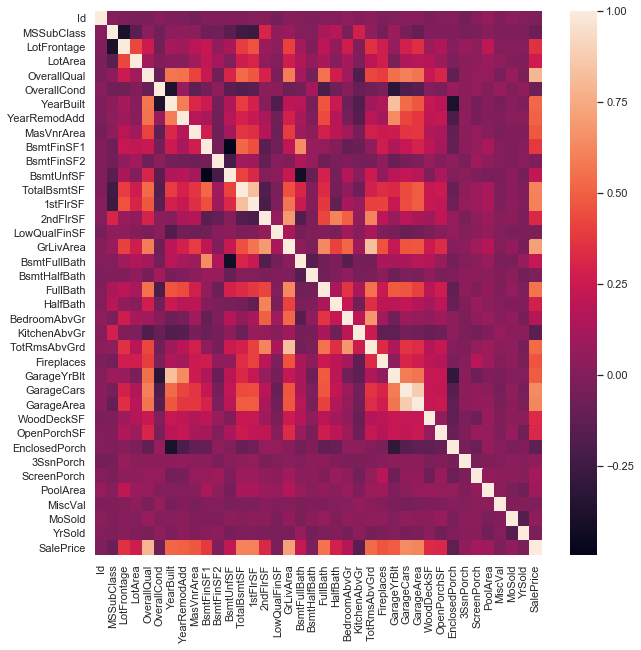

In [8]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_train.corr())
plt.plot()

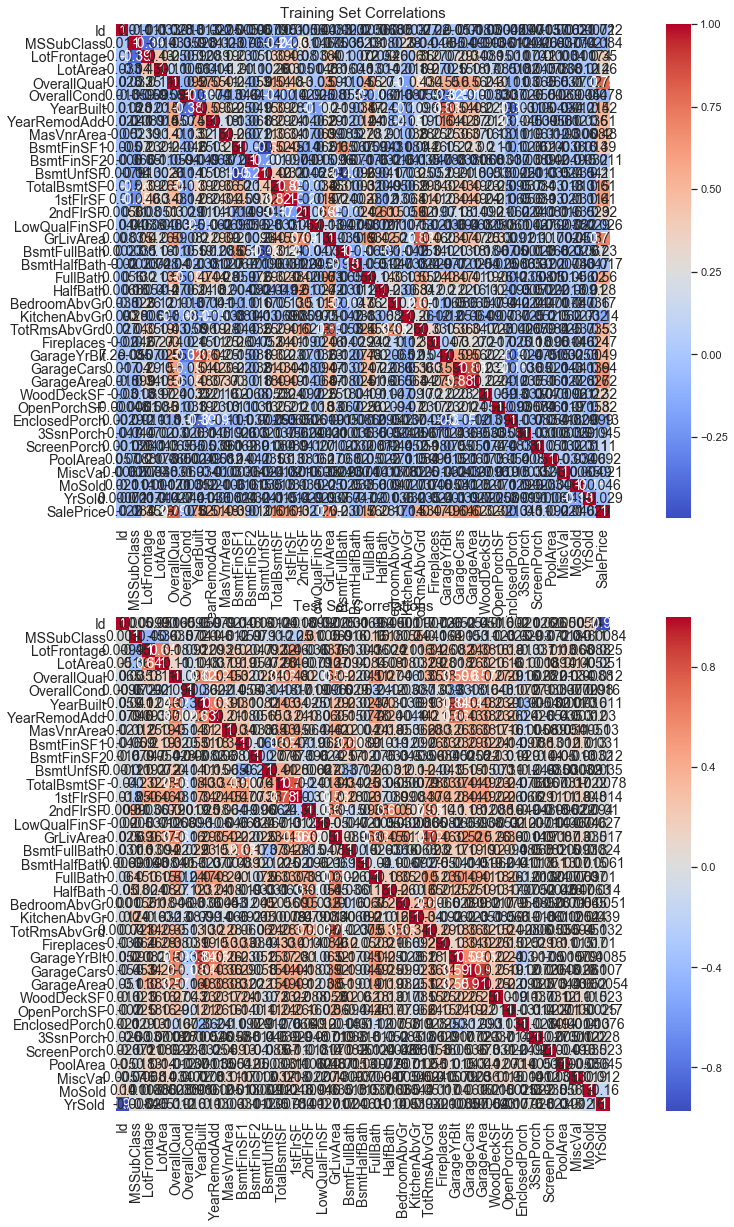

In [9]:
#df_train.corr().sort().abs()
"""
df_train_corr = df_train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]
"""

fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

In [10]:
df_corr=df_train.corr().sort_values(kind="quicksort", ascending=False, by='SalePrice').abs()
df_corr.drop(axis=1, columns=df_corr.columns.drop('SalePrice'), inplace=True)
df_corr

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [11]:
# df_train['Alley'].isnull().sum() = show number of NaN rows in 'Alley' column

In [12]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

In [14]:
def display_missing(df):
    for col in df.columns:
        print(col, df[col].isnull().sum())
    print('\n')
    
for df in dfs:
    print(format(df.name))
    display_missing(df)

Training Set
Id 0
MSSubClass 0
MSZoning 0
LotFrontage 259
LotArea 0
Street 0
Alley 1369
LotShape 0
LandContour 0
Utilities 0
LotConfig 0
LandSlope 0
Neighborhood 0
Condition1 0
Condition2 0
BldgType 0
HouseStyle 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
RoofStyle 0
RoofMatl 0
Exterior1st 0
Exterior2nd 0
MasVnrType 8
MasVnrArea 8
ExterQual 0
ExterCond 0
Foundation 0
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinSF1 0
BsmtFinType2 38
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
Heating 0
HeatingQC 0
CentralAir 0
Electrical 1
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 0
BsmtHalfBath 0
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
KitchenQual 0
TotRmsAbvGrd 0
Functional 0
Fireplaces 0
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageCars 0
GarageArea 0
GarageQual 81
GarageCond 81
PavedDrive 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
PoolQC 1453
Fence 1179
MiscFeature 1406
MiscVal 0
M

In [15]:
"""### Dealing with missing values
to improve in future - may be not median of overall but 
Missing values in 'LotFrontage' feature are filled with the median LotFrontage, but using the median age of the whole data set is not a good choice. Median age of a group is much better because the new values would be more informative. Median age of Pclass groups is the best choice because of its high correlation with Age (0.408106) and Survived (0.338481) features
"""

"### Dealing with missing values\nto improve in future - may be not median of overall but \nMissing values in 'LotFrontage' feature are filled with the median LotFrontage, but using the median age of the whole data set is not a good choice. Median age of a group is much better because the new values would be more informative. Median age of Pclass groups is the best choice because of its high correlation with Age (0.408106) and Survived (0.338481) features\n"

In [16]:
df_train['OverallQual'].describe()

count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

In [17]:
#df_train_copy=df_train['LotFrontage'].copy()
    #df_train_copy
#df_train_copy.fillna(value=df_train['LotFrontage'].mean())

In [18]:
#df_train['LotFrontage'].mean()

# Machine Learning

In [19]:
#Dele
df_train_no_obj=df_train.select_dtypes(exclude=['object'])
df_test_no_obj=df_test.select_dtypes(exclude=['object'])

In [20]:
def display_missing(df):
    for col in df.columns:
        print(col, df[col].isnull().sum())
    print('\n')
    
display_missing(df_test_no_obj)

Id 0
MSSubClass 0
LotFrontage 227
LotArea 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
MasVnrArea 15
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 2
BsmtHalfBath 2
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
TotRmsAbvGrd 0
Fireplaces 0
GarageYrBlt 78
GarageCars 1
GarageArea 1
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
MiscVal 0
MoSold 0
YrSold 0




In [21]:
#drop NA values in train set - for time save
df_train_no_obj.dropna(inplace=True)
#df_test_no_obj.dropna(inplace=True)

In [22]:
# change NA values in test set - to mean
def nan_to_mean(df):
    for col in df.columns:
        df[col].fillna(value=df[col].mean(), inplace=True)
        print(col, df[col].mean())
        
nan_to_mean(df_test_no_obj)

Id 2190.0
MSSubClass 57.37834132967786
LotFrontage 68.58035714285695
LotArea 9819.161069225496
OverallQual 6.078821110349555
OverallCond 5.5538039753255655
YearBuilt 1971.357779300891
YearRemodAdd 1983.6627827278958
MasVnrArea 100.70914127423828
BsmtFinSF1 439.2037037037037
BsmtFinSF2 52.61934156378601
BsmtUnfSF 554.2949245541838
TotalBsmtSF 1046.1179698216736
1stFlrSF 1156.534612748458
2ndFlrSF 325.96778615490064
LowQualFinSF 3.5435229609321452
GrLivArea 1486.0459218642907
BsmtFullBath 0.43445435827041873
BsmtHalfBath 0.06520247083047358
FullBath 1.570938999314599
HalfBath 0.3776559287183002
BedroomAbvGr 2.8540095956134337
KitchenAbvGr 1.0424948594928032
TotRmsAbvGrd 6.385195339273475
Fireplaces 0.5812200137080192
GarageYrBlt 1977.7212165097733
GarageCars 1.7661179698216736
GarageArea 472.76886145404666
WoodDeckSF 93.17477724468814
OpenPorchSF 48.3139136394791
EnclosedPorch 24.24331734064428
3SsnPorch 1.794379712131597
ScreenPorch 17.064427690198766
PoolArea 1.7443454420836189
MiscVal

In [23]:
display_missing(df_test_no_obj)

Id 0
MSSubClass 0
LotFrontage 0
LotArea 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
MasVnrArea 0
BsmtFinSF1 0
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 0
BsmtHalfBath 0
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
TotRmsAbvGrd 0
Fireplaces 0
GarageYrBlt 0
GarageCars 0
GarageArea 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
MiscVal 0
MoSold 0
YrSold 0




In [24]:
y_train = df_train_no_obj['SalePrice'].values
drop_columns= ['SalePrice','Id']
X_train = df_train_no_obj.drop(columns=drop_columns)
X_val= df_test_no_obj.drop(columns='Id')

In [25]:
y_train.shape

(1121,)

In [26]:
y_train=y_train.reshape(-1,1)
#X_train_no_obj.dropna(inplace=True)
X_train=X_train.astype(np.float32)
X_val=X_val.astype(np.float32)

In [27]:
X_val.shape

(1459, 36)

In [28]:
X_val

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20.0,80.00000,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,144.0,...,730.0,140.0,0.0,0.0,0.0,120.0,0.0,0.0,6.0,2010.0
1,20.0,81.00000,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,0.0,...,312.0,393.0,36.0,0.0,0.0,0.0,0.0,12500.0,6.0,2010.0
2,60.0,74.00000,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,0.0,...,482.0,212.0,34.0,0.0,0.0,0.0,0.0,0.0,3.0,2010.0
3,60.0,78.00000,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,0.0,...,470.0,360.0,36.0,0.0,0.0,0.0,0.0,0.0,6.0,2010.0
4,120.0,43.00000,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,0.0,...,506.0,0.0,82.0,0.0,0.0,144.0,0.0,0.0,1.0,2010.0
5,60.0,75.00000,10000.0,6.0,5.0,1993.0,1994.0,0.0,0.0,0.0,...,440.0,157.0,84.0,0.0,0.0,0.0,0.0,0.0,4.0,2010.0
6,20.0,68.58036,7980.0,6.0,7.0,1992.0,2007.0,0.0,935.0,0.0,...,420.0,483.0,21.0,0.0,0.0,0.0,0.0,500.0,3.0,2010.0
7,60.0,63.00000,8402.0,6.0,5.0,1998.0,1998.0,0.0,0.0,0.0,...,393.0,0.0,75.0,0.0,0.0,0.0,0.0,0.0,5.0,2010.0
8,20.0,85.00000,10176.0,7.0,5.0,1990.0,1990.0,0.0,637.0,0.0,...,506.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0
9,20.0,70.00000,8400.0,4.0,5.0,1970.0,1970.0,0.0,804.0,78.0,...,525.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2010.0


In [30]:
forest_model = RandomForestRegressor()

#forest_model = RandomForestClassifier
forest_model.fit(X_train, y_train)
forest_model.score(X_train, y_train)
y_pred = forest_model.predict(X_val)
#print(mean_squared_error(y_val, survival_preds))
#print(mean_absolute_error(y_val, survival_preds))

In [31]:
forest_model.score(X_train, y_train)


0.9699294061921652

# Submission

In [280]:
submission_df = pd.DataFrame(columns=['Id', 'SalePrice'])
submission_df['Id'] = df_test_no_obj['Id']
submission_df['SalePrice'] = y_pred
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

,Id,SalePrice
0,1461,121100.0
1,1462,154040.0
2,1463,179014.0
3,1464,186150.0
4,1465,202740.0
5,1466,166683.2
6,1467,166272.2
7,1468,172848.0
8,1469,182374.0
9,1470,119165.0
